In [288]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
plt.style.use('ggplot')
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ARDRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

# PCA

Количество дифференцирований для каждого ряда:
{'infl_rus': 0, 'MIACR': 1, 'Infl_exp': 0, 'M2': 2, 'Brent': 1, 'ibk': 0}

Стационарные ряды:
     infl_rus     MIACR   Infl_exp      M2  Brent       ibk
0        0.39       NaN  13.037736     NaN    NaN  6.523469
1        0.49 -0.062971  11.795154     NaN   0.78  6.163086
2        0.82  1.851500  11.522133  1602.2  -1.42  6.070468
3        0.87  0.029545  12.672745  -957.5   0.28  5.469189
4        0.85  0.340191  11.720957  1009.4   1.78  6.261563
..        ...       ...        ...     ...    ...       ...
127      0.60  1.598735  12.520500  -244.0  -4.79  6.020449
128      0.75  0.699091  13.412700  1097.3  -6.34  4.607483
129      0.81  0.465217  13.366700  -504.6   1.61  5.307674
130      1.10  1.720497  13.941200   -68.4  -1.28  5.006505
131      1.02  0.494286  14.033000   758.9  -0.49  4.334876

[132 rows x 6 columns]


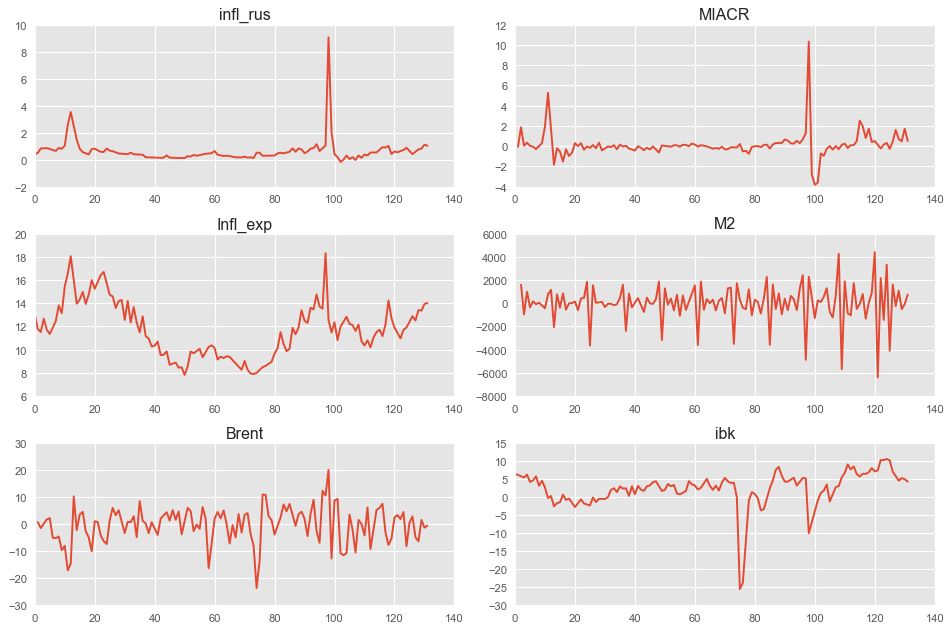

In [289]:
def check_stationarity(series, alpha=0.05):
    """
    Проверка стационарности с помощью теста Дики-Фуллера.
    Возвращает True, если ряд стационарный, иначе False.
    """
    result = adfuller(series)
    p_value = result[1]
    return p_value <= alpha

# Функция для приведения ряда к стационарному виду
def make_stationary(series, max_diff=5):
    """
    Приводит ряд к стационарному виду с помощью дифференцирования.
    Возвращает стационарный ряд и количество примененных дифференцирований.
    """
    diff_count = 0
    while not check_stationarity(series) and diff_count < max_diff:
        series = series.diff().dropna()
        diff_count += 1
    return series, diff_count

df = pd.read_csv('infl_rus.csv')
df = df.iloc[:, 2:]

# Применение ко всем столбцам DataFrame
stationary_df = pd.DataFrame()
diff_counts = {}

for column in df.columns:
    series = df[column]
    stationary_series, diff_count = make_stationary(series)
    stationary_df[column] = stationary_series
    diff_counts[column] = diff_count

# Вывод результатов
print("Количество дифференцирований для каждого ряда:")
print(diff_counts)

print("\nСтационарные ряды:")
print(stationary_df)

# Визуализация стационарных рядов
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for i, column in enumerate(stationary_df.columns, 1):
    plt.subplot(3, 2, i)
    plt.plot(stationary_df[column])
    plt.title(column)
plt.tight_layout()
plt.show()

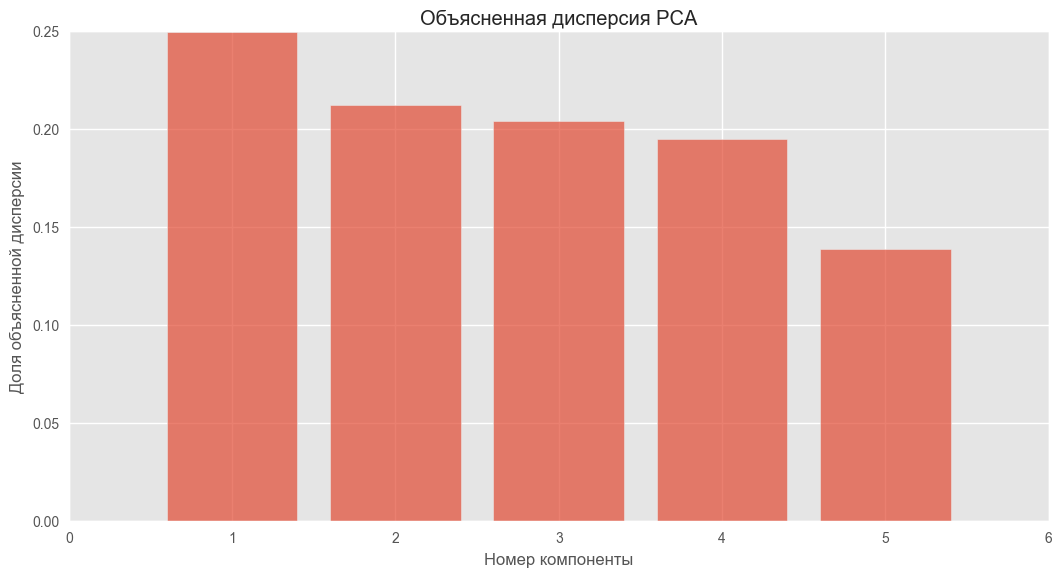

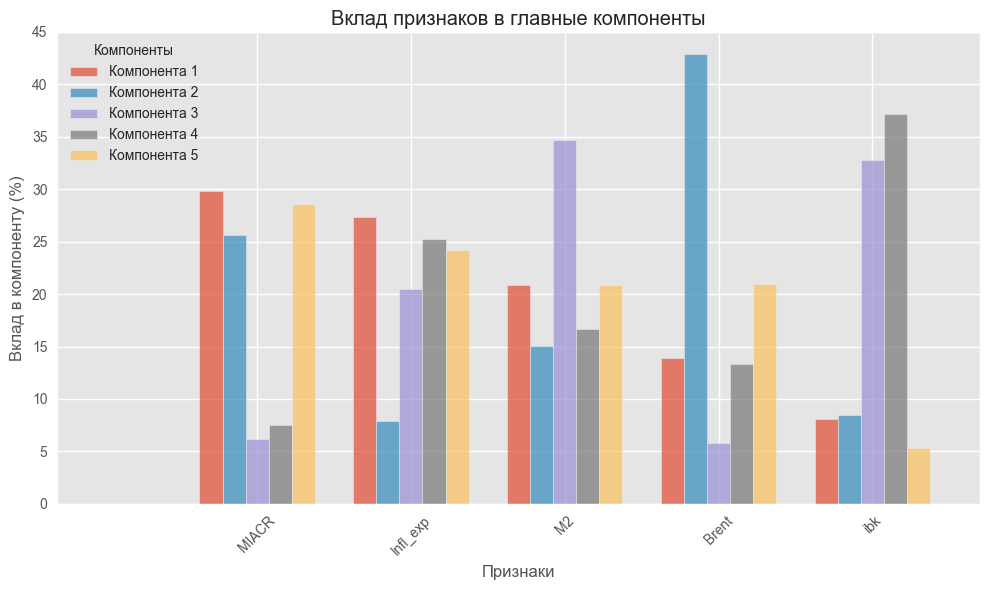


Анализ компоненты 1 (объясняет 24.94% дисперсии):
MIACR влияет на инфляцию со значением 29.80%
Infl_exp влияет на инфляцию со значением 27.34%
M2 влияет на инфляцию со значением 20.85%
Brent влияет на инфляцию со значением 13.88%
ibk влияет на инфляцию со значением 8.14%

Анализ компоненты 2 (объясняет 21.22% дисперсии):
MIACR влияет на инфляцию со значением 25.62%
Infl_exp влияет на инфляцию со значением 7.90%
M2 влияет на инфляцию со значением 15.09%
Brent влияет на инфляцию со значением 42.94%
ibk влияет на инфляцию со значением 8.44%

Анализ компоненты 3 (объясняет 20.43% дисперсии):
MIACR влияет на инфляцию со значением 6.16%
Infl_exp влияет на инфляцию со значением 20.46%
M2 влияет на инфляцию со значением 34.72%
Brent влияет на инфляцию со значением 5.84%
ibk влияет на инфляцию со значением 32.82%

Анализ компоненты 4 (объясняет 19.52% дисперсии):
MIACR влияет на инфляцию со значением 7.53%
Infl_exp влияет на инфляцию со значением 25.25%
M2 влияет на инфляцию со значением 16.70

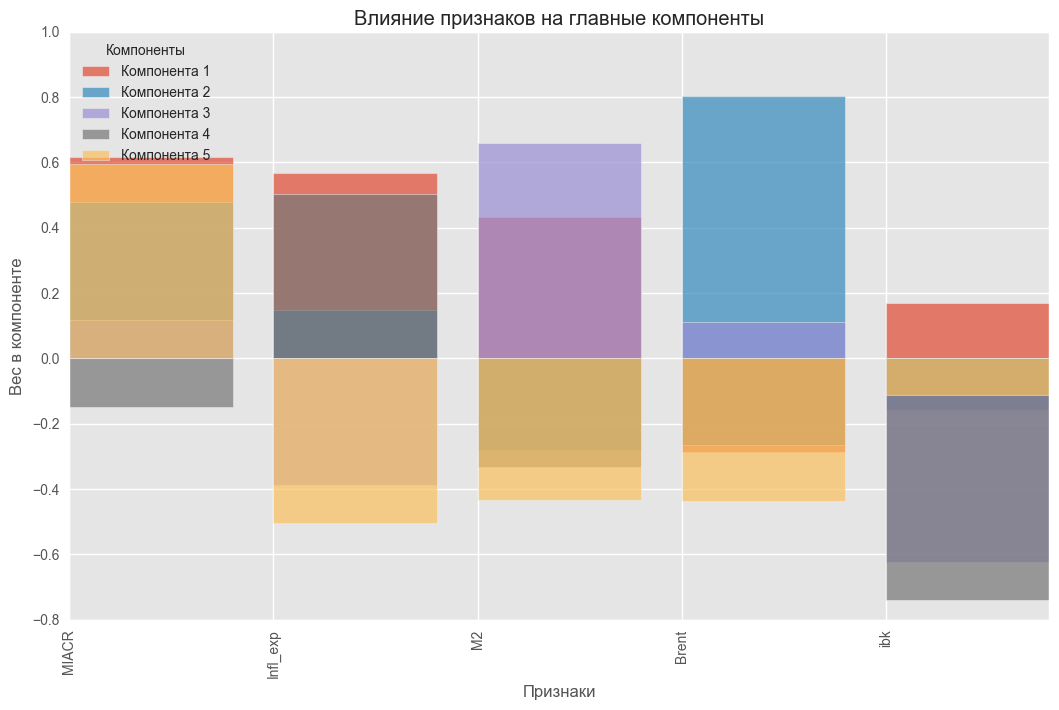

In [293]:
df = stationary_df.dropna().copy()
# Отделяем целевую переменную (инфляция) и признаки
X = df.drop(columns=["infl_rus"])  # Признаки
y = df["infl_rus"]  # Целевая переменная (инфляция)

# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Применение PCA
# Порог объясняющей дисперсии - 95%
#   Есть альтернативы: критерий "локтя" или критерий Кайзера 
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Анализ результатов
explained_variance = pca.explained_variance_ratio_
loadings = pca.components_

# Визуализация объясненной дисперсии
plt.figure(figsize=(10, 5), dpi=100)
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center')
plt.xlabel('Номер компоненты')
plt.ylabel('Доля объясненной дисперсии')
plt.title('Объясненная дисперсия PCA')
plt.show()

# Вычисляем вклад каждого признака в компоненты (в процентах)
feature_names = X.columns
contributions = []
for i, component in enumerate(loadings):
    contribution = np.abs(component) / np.sum(np.abs(component)) * 100
    contributions.append(contribution)

# Преобразуем в DataFrame для удобства
contributions_df = pd.DataFrame(contributions, columns=feature_names)
contributions_df.index = [f"Компонента {i + 1}" for i in range(len(contributions))]

# Визуализация
plt.figure(figsize=(10, 6), dpi=100)
bar_width = 0.15  # Ширина столбцов
n_components = len(contributions_df)  # Количество компонент
n_features = len(feature_names)  # Количество признаков

# Позиции для столбцов
positions = np.arange(n_features)

for i in range(n_components):
    plt.bar(
        positions + i * bar_width,  # Смещение для каждой компоненты
        contributions_df.iloc[i],   # Вклад признаков в компоненту
        width=bar_width,            # Ширина столбцов
        label=contributions_df.index[i],  # Легенда
        alpha=0.7
    )

# Настройка графика
plt.xticks(positions + (n_components - 1) * bar_width / 2, feature_names, rotation=45)
plt.xlabel("Признаки")
plt.ylabel("Вклад в компоненту (%)")
plt.title("Вклад признаков в главные компоненты")
plt.legend(title="Компоненты", loc='upper left')
plt.tight_layout()
plt.show()


# Вывод влияния параметров на инфляцию
feature_names = X.columns
for i, component in enumerate(loadings):
    print(f"\nАнализ компоненты {i + 1} (объясняет {explained_variance[i] * 100:.2f}% дисперсии):")
    for j, weight in enumerate(component):
        # Вычисляем вклад параметра в компоненту (в процентах)
        contribution = abs(weight) / np.sum(np.abs(component)) * 100
        print(f"{feature_names[j]} влияет на инфляцию со значением {contribution:.2f}%")

# Визуализация весов компонент
plt.figure(figsize=(10, 6), dpi=100)
for i, component in enumerate(loadings):
    plt.bar(feature_names, component, alpha=0.7, label=f'Компонента {i + 1}', align='edge')
plt.xticks(rotation=90)
plt.xlabel('Признаки')
plt.ylabel('Вес в компоненте')
plt.title('Влияние признаков на главные компоненты')
plt.legend(title="Компоненты", loc='upper left')
plt.show()

# МНК

In [280]:
# Пример данных
df = pd.read_csv('infl_rus.csv')
df = df.iloc[:, 2:]
df

,infl_rus,MIACR,Infl_exp,M2,Brent,ibk
0,0.39,6.056471,13.037736,31155.6,108.12,6.523469
1,0.49,5.993500,11.795154,29861.2,108.90,6.163086
2,0.82,7.845000,11.522133,30169.0,107.48,6.070468
3,0.87,7.874545,12.672745,29519.3,107.76,5.469189
4,0.85,8.214737,11.720957,29879.0,109.54,6.261563
...,...,...,...,...,...,...
127,0.60,17.760909,12.520500,104351.3,80.36,6.020449
128,0.75,18.460000,13.412700,106242.7,74.02,4.607483
129,0.81,18.925217,13.366700,107629.5,75.63,5.307674
130,1.10,20.645714,13.941200,108947.9,74.35,5.006505


In [294]:
df = stationary_df.dropna().copy()

# Отделяем целевую переменную (инфляция) и признаки
X = df.drop(columns=["infl_rus"])  # Признаки
y = df["infl_rus"]  # Целевая переменная (инфляция)

# Добавляем константу (intercept) к признакам
X = sm.add_constant(X)

# Построение модели МНК
model = sm.OLS(y, X)  # Определяем модель
results = model.fit()  # Обучаем модель

# Вывод результатов
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               infl_rus   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     42.72
Date:                Thu, 13 Mar 2025   Prob (F-statistic):           2.07e-25
Time:                        09:20:34   Log-Likelihood:                -103.05
No. Observations:                 130   AIC:                             218.1
Df Residuals:                     124   BIC:                             235.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4130      0.250     -1.652      0.1

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Оптимальный порядок лагов: 3
FEVD for infl_rus
     infl_rus     MIACR  Infl_exp        M2     Brent       ibk
0    1.000000  0.000000  0.000000  0.000000  0.000000  0.000000
1    0.638714  0.077571  0.262146  0.014209  0.007347  0.000012

FEVD for MIACR
     infl_rus     MIACR  Infl_exp        M2     Brent       ibk
0    0.655291  0.344709  0.000000  0.000000  0.000000  0.000000
1    0.405748  0.333773  0.222300  0.007359  0.030818  0.000001

FEVD for Infl_exp
     infl_rus     MIACR  Infl_exp        M2     Brent       ibk
0    0.021746  0.048256  0.929998  0.000000  0.000000  0.000000
1    0.052086  0.105083  0.823216  0.000820  0.001241  0.017553

FEVD for M2
     infl_rus     MIACR  Infl_exp        M2     Brent       ibk
0    0.000703  0.004813  0.017464  0.977020  0.000000  0.000000
1    0.023480  0.036088  0.021242  0.912663  0.006414  0.000112

FEVD for Brent
     infl_rus     MIACR  Infl_exp        M2     Brent       ibk
0    0.072808  0.010827  0.016080  0.004114  0.896171  0.

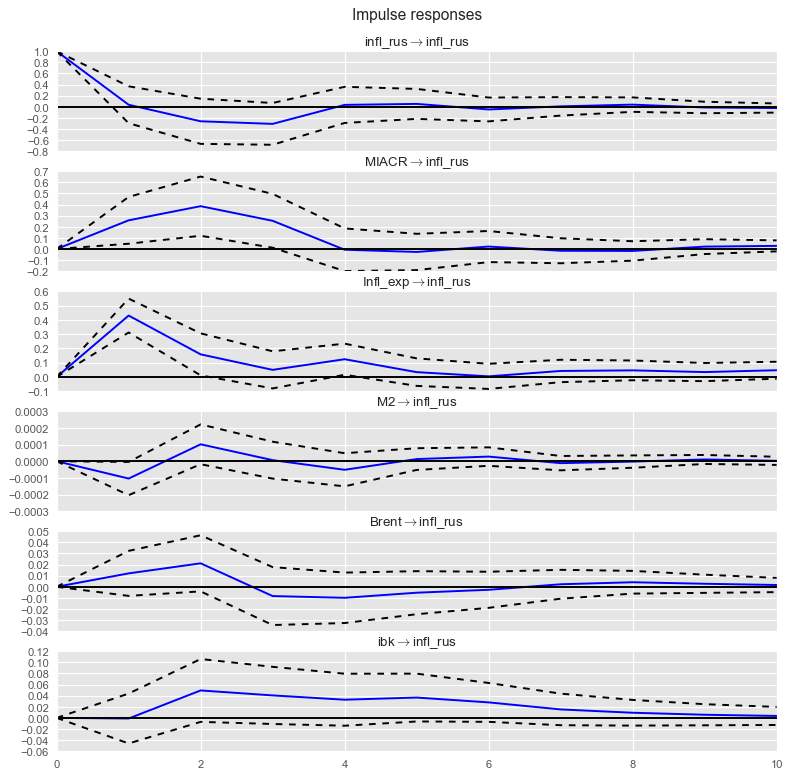

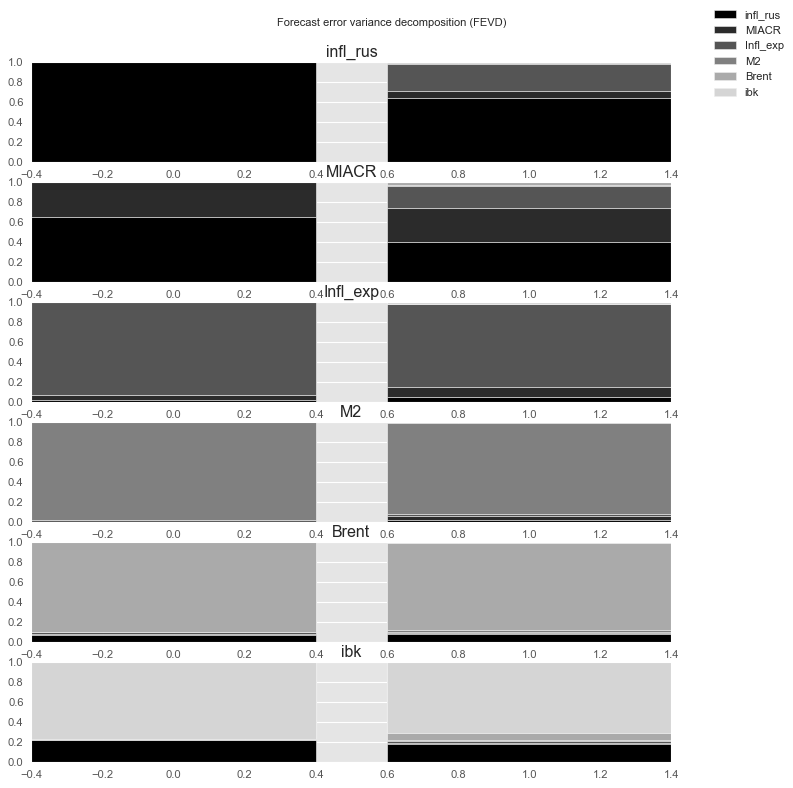

In [295]:
from statsmodels.tsa.api import VAR

model = VAR(df)

# Выбор оптимального порядка лагов
lag_order = model.select_order(maxlags=5)
print("Оптимальный порядок лагов:", lag_order.aic)

# Подгонка модели с выбранным порядком лагов
results = model.fit(maxlags=lag_order.aic, ic='aic')

# Анализ импульсных откликов
irf = results.irf(10)
irf.plot(response='infl_rus')

# Доля дисперсии инфляции
fevd = results.fevd(2) 
fevd.summary()
fevd.plot()
plt.show()

In [296]:
from statsmodels.tsa.ar_model import AutoReg

# Построение ARDL модели
model = AutoReg(df['infl_rus'], lags=2, exog=df[['MIACR', 'Infl_exp', 'M2', 'Brent', 'ibk']])
results = model.fit()
print(results.summary())

                            AutoReg Model Results                             
Dep. Variable:               infl_rus   No. Observations:                  130
Model:                   AutoReg-X(2)   Log Likelihood                 -58.996
Method:               Conditional MLE   S.D. of innovations              0.384
Date:                Thu, 13 Mar 2025   AIC                            135.993
Time:                        09:21:13   BIC                            161.661
Sample:                             2   HQIC                           146.422
                                  130                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0320      0.181      0.177      0.860      -0.323       0.387
infl_rus.L1     0.3874      0.043      8.933      0.000       0.302       0.472
infl_rus.L2     0.1666      0.046      3.661    

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


MSE: 0.7797019743054732
R^2: -0.2779430428563574
     Фактор  Коэффициент
0     const     0.000000
1     MIACR     0.517418
2  Infl_exp     0.065433
3        M2     0.000000
4     Brent     0.024326
5       ibk    -0.027642


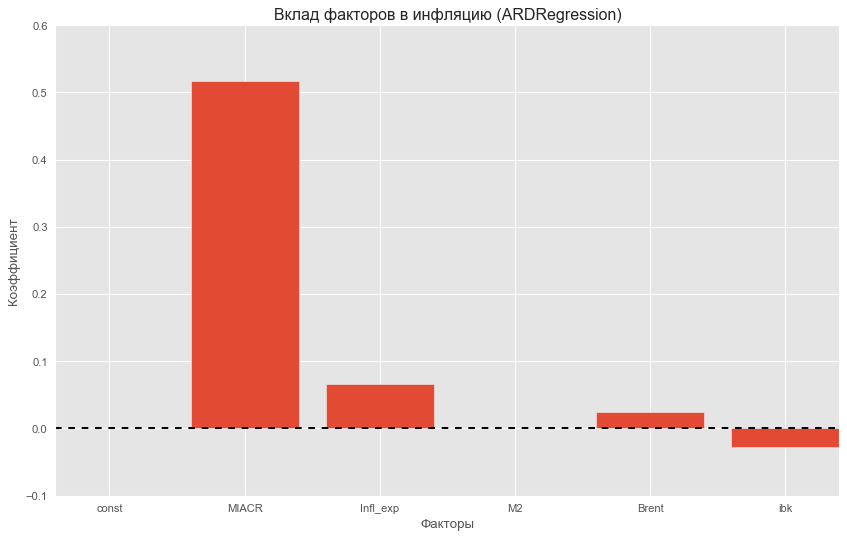

In [297]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Построение модели ARDRegression
model = ARDRegression()
model.fit(X_train, y_train)

# Прогнозирование на тестовой выборке
y_pred = model.predict(X_test)

# Оценка модели
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse}")
print(f"R^2: {r2}")

# Вывод коэффициентов модели
coefficients = pd.DataFrame({
    'Фактор': X.columns,
    'Коэффициент': model.coef_
})
print(coefficients)

# Визуализация коэффициентов
plt.figure(figsize=(10, 6))
plt.bar(coefficients['Фактор'], coefficients['Коэффициент'])
plt.axhline(0, color='black', linestyle='--')
plt.title('Вклад факторов в инфляцию (ARDRegression)')
plt.xlabel('Факторы')
plt.ylabel('Коэффициент')
plt.show()

Плохая модель, ничего не объясняет толком

# CatBoost

In [300]:
df = stationary_df.dropna().copy()

# Разделяем данные на признаки (X) и целевую переменную (y)
X = df.drop('infl_rus', axis=1)
y = df['infl_rus']

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создаем и обучаем модель CatBoostRegressor
model = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=3, verbose=0)
model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = model.predict(X_test)

# Оценка модели
mse = mean_squared_error(y_test, y_pred)
print(f'Среднеквадратичная ошибка (MSE): {mse:.4f}')

# Важность признаков
feature_importance = model.get_feature_importance()
feature_names = X.columns

# Вывод важности признаков
print('\nВажность признаков:')
for feature, importance in zip(feature_names, feature_importance):
    print(f'{feature}: {importance:.2f}')

# Интерпретация влияния факторов на инфляцию
total_importance = sum(feature_importance)
print('\nВлияние факторов на инфляцию:')
for feature, importance in zip(feature_names, feature_importance):
    print(f'{feature}: {importance / total_importance * 100:.2f}%')

Среднеквадратичная ошибка (MSE): 0.4886

Важность признаков:
MIACR: 42.58
Infl_exp: 13.86
M2: 0.98
Brent: 39.94
ibk: 2.64

Влияние факторов на инфляцию:
MIACR: 42.58%
Infl_exp: 13.86%
M2: 0.98%
Brent: 39.94%
ibk: 2.64%


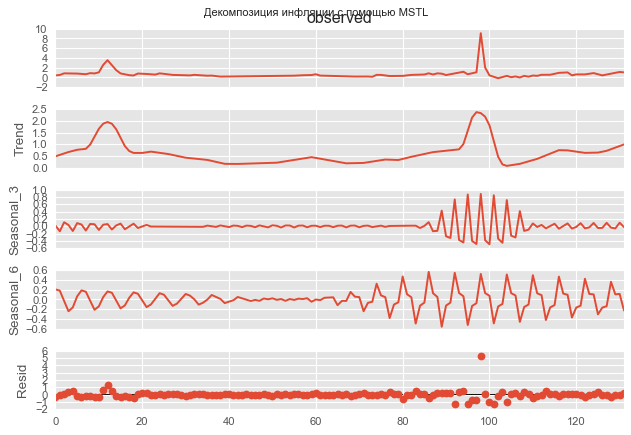

Влияние факторов на тренд инфляции:
     Фактор  Коэффициент
0     MIACR     0.027221
1  Infl_exp     0.098196
2        M2    -0.000001
3     Brent     0.008977
4       ibk    -0.026364


In [301]:
from statsmodels.tsa.seasonal import MSTL
from sklearn.linear_model import LinearRegression

# Создание DataFrame
df = pd.read_csv('infl_rus.csv')
df = df.iloc[:, 2:]

# Декомпозиция ряда инфляции с помощью MSTL
mstl = MSTL(df['infl_rus'], periods=(3, 6))  # Периоды сезонности (можно настроить)
decomposition = mstl.fit()

# Визуализация декомпозиции
decomposition.plot()
plt.suptitle('Декомпозиция инфляции с помощью MSTL')
plt.show()

# Анализ влияния факторов на тренд инфляции
# Используем тренд как целевую переменную
trend = decomposition.trend.dropna()
X = df.loc[trend.index, ['MIACR', 'Infl_exp', 'M2', 'Brent', 'ibk']]  # Факторы

# Построение линейной регрессии для анализа влияния факторов на тренд
model = LinearRegression()
model.fit(X, trend)

# Вывод коэффициентов
coefficients = pd.DataFrame({
    'Фактор': X.columns,
    'Коэффициент': model.coef_
})
print("Влияние факторов на тренд инфляции:")
print(coefficients)
